## Máster en Data Science - Series Temporales

# Google Causal Impact Model
Autor: Ramón Morillo Barrera

## Dataset: Madrid.csv

El modelo Causal Impact, desarrollado por Google, es una herramienta estadística diseñada para evaluar el impacto causal de un evento o intervención en una serie temporal. Basado en modelos bayesianos estructurales, este enfoque permite estimar lo que habría ocurrido en ausencia de la intervención, proporcionando una comparación entre los datos observados y las predicciones contrafactuales. Este modelo es particularmente útil en contextos como el análisis del impacto de campañas publicitarias, cambios en políticas empresariales o cualquier evento externo que pueda influir en el comportamiento de una métrica clave. Causal Impact es fácil de implementar gracias a su disponibilidad en R y Python, y su metodología robusta permite obtener inferencias fiables sobre la causalidad incluso en presencia de ruido en los datos.

In [1]:
# librerías
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


### Importar datos

In [2]:
df_autobus_month = pd.read_csv('../data/processed/Madrid_autobus_month.csv', index_col='Periodo')
df_metro_month = pd.read_csv('../data/processed/Madrid_metro_month.csv', index_col='Periodo')
df_combined_month = pd.read_csv('../data/processed/Madrid_combined_month.csv', index_col='Periodo')

df_autobus_trim = pd.read_csv('../data/processed/Madrid_autobus_trim.csv', index_col='Periodo')
df_metro_trim = pd.read_csv('../data/processed/Madrid_metro_trim.csv', index_col='Periodo')
df_combined_trim = pd.read_csv('../data/processed/Madrid_combined_trim.csv', index_col='Periodo')

In [3]:
df_autobus_month = df_autobus_month[ 'Total']
df_autobus_trim = df_autobus_trim['Total']
df_combined_month = df_combined_month[ 'Total']
df_combined_trim = df_combined_trim['Total']
df_metro_month = df_metro_month['Total']
df_metro_trim = df_metro_trim['Total']

In [4]:
df_autobus_month.index = pd.to_datetime(df_autobus_month.index)
df_autobus_trim.index = pd.to_datetime(df_autobus_trim.index)
df_combined_month.index = pd.to_datetime(df_combined_month.index)
df_combined_trim.index = pd.to_datetime(df_combined_trim.index)
df_metro_month.index = pd.to_datetime(df_metro_month.index)
df_metro_trim.index = pd.to_datetime(df_metro_trim.index)

df_autobus_month = df_autobus_month.resample("M").last()
df_autobus_trim = df_autobus_trim.resample("QE").last()
df_combined_month = df_combined_month.resample("M").last()
df_combined_trim = df_combined_trim.resample("QE").last()
df_metro_month = df_metro_month.resample("M").last()
df_metro_trim = df_metro_trim.resample("QE").last()

***

## Modelo Causal Impact 

El modelo Causal Impact es una metodología estadística que utiliza series temporales para medir el efecto de una intervención, comparando los datos observados con estimaciones contrafactuales generadas a partir de datos previos. Su enfoque bayesiano facilita la identificación de cambios atribuibles al evento analizado, siendo especialmente valioso en evaluaciones de impacto donde los experimentos controlados no son factibles.

### Series mensuales

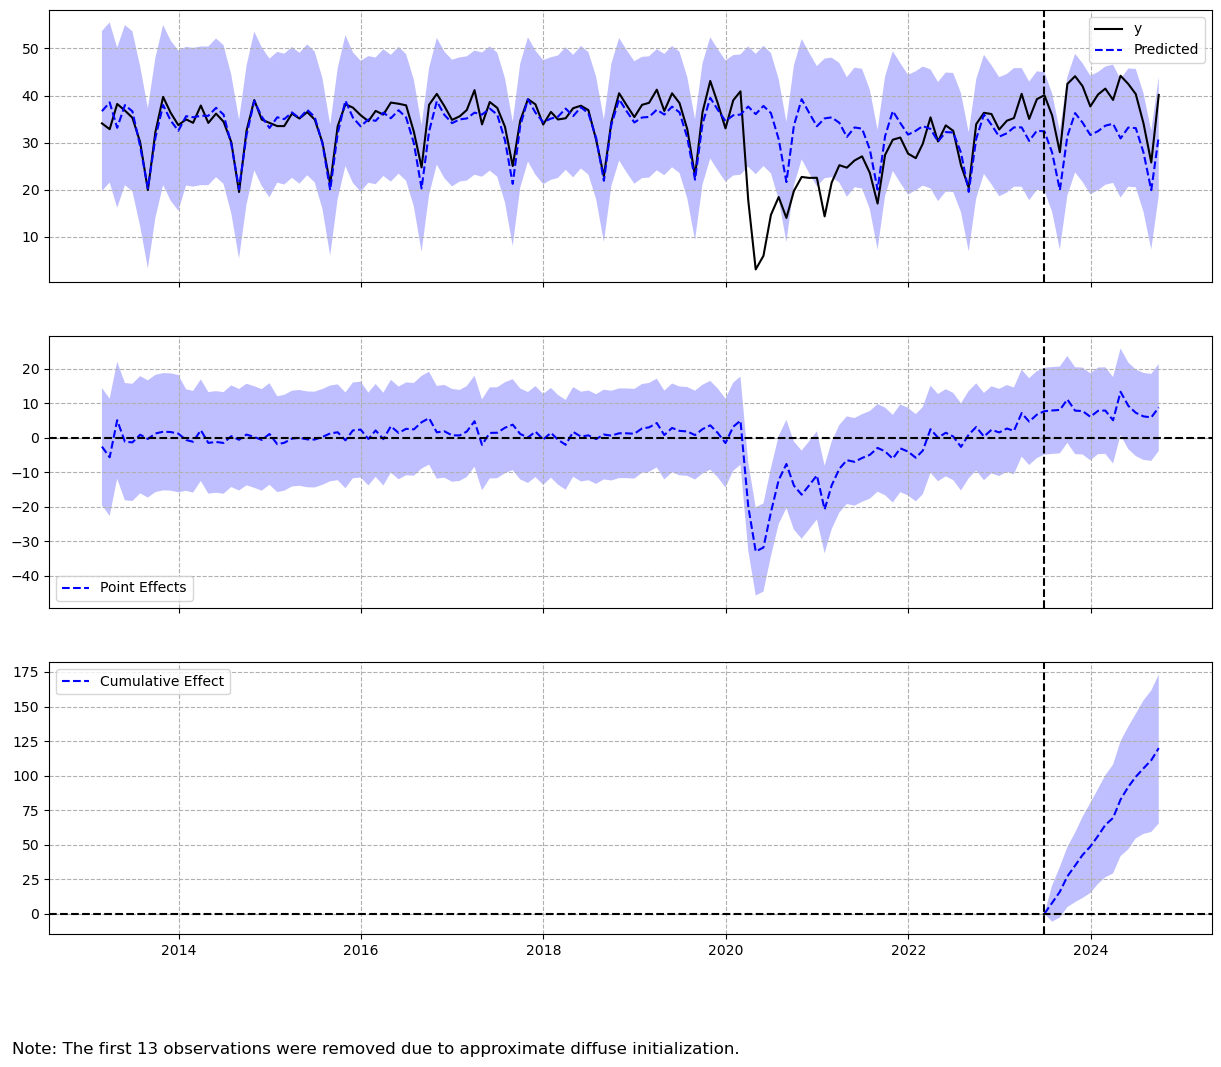

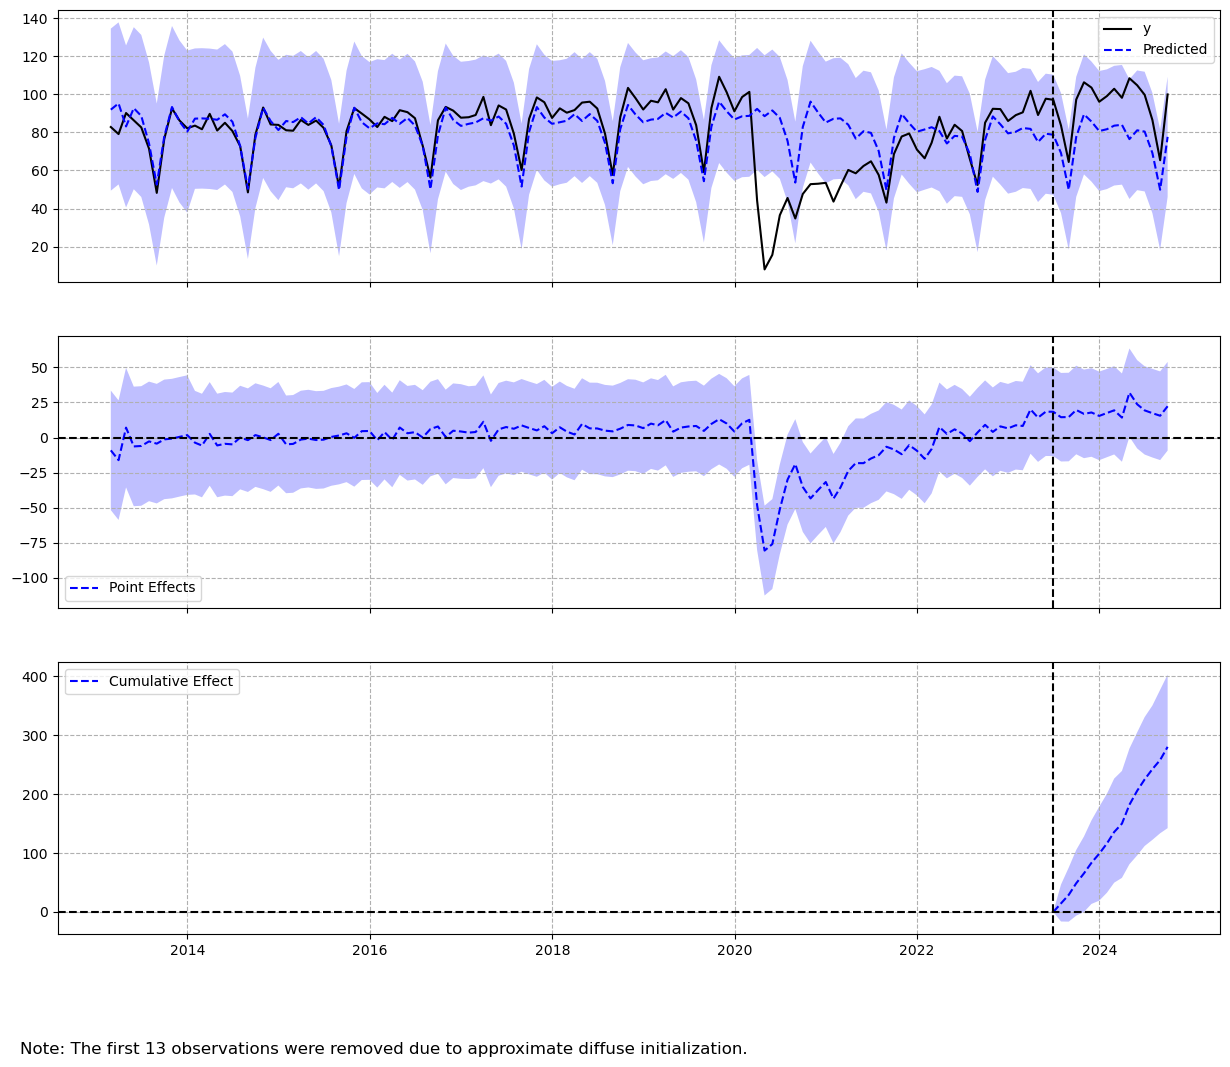

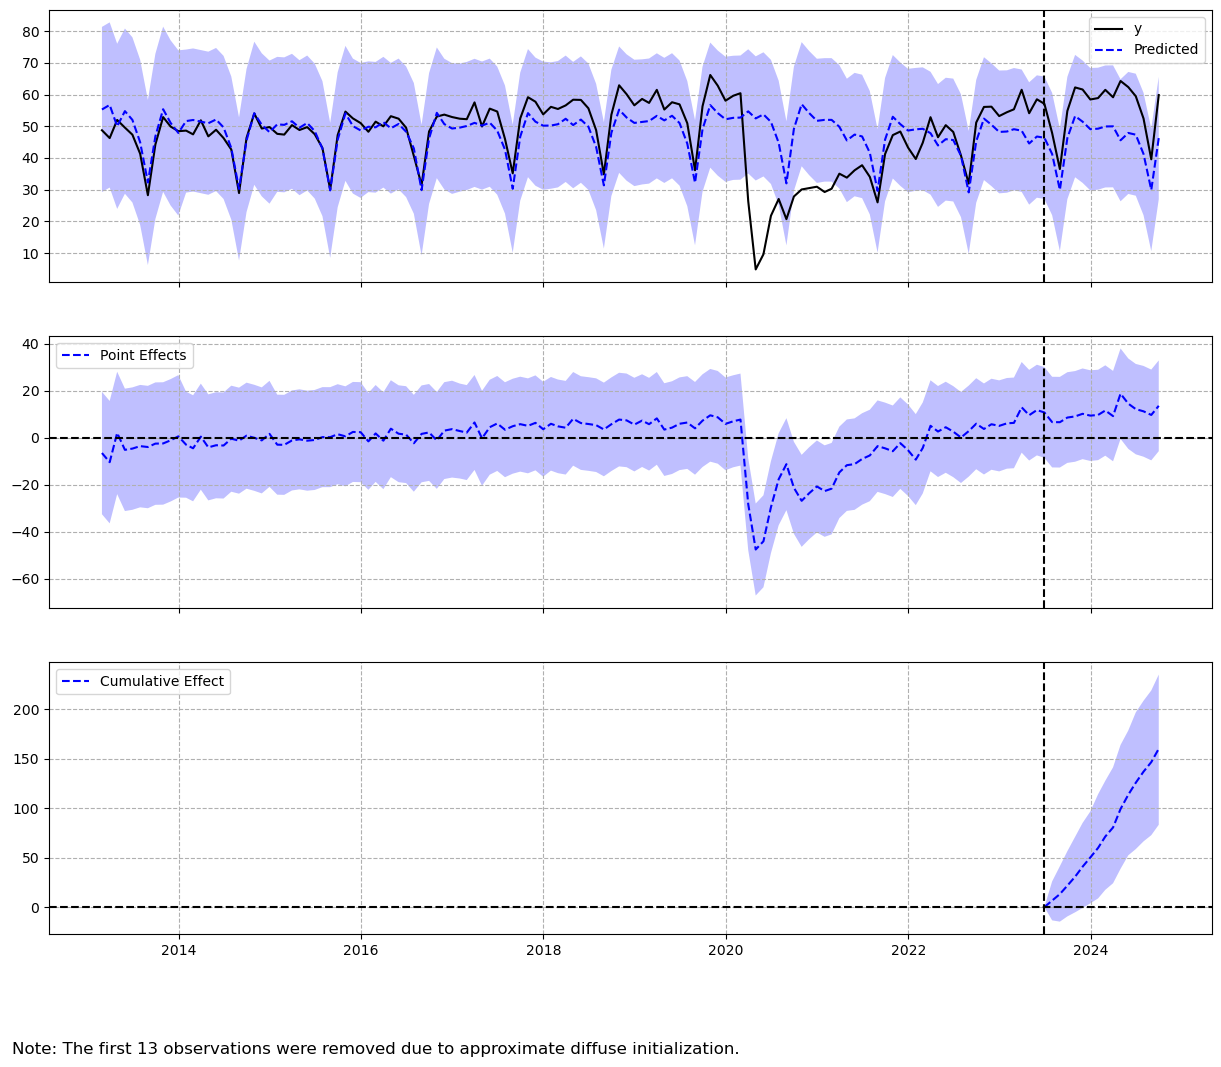

In [9]:
def train_and_plot_causal_impact(data, pre_period, post_period):
    # Entrenar el modelo CausalImpact
    ci = CausalImpact(data, pre_period, post_period, model_args={'fit_method': 'vi'},nseasons=[{'period': 12}], seasonal_duration=30)
    
    # Graficar los resultados
    ci.plot()
    plt.show()

# Definir el periodo de intervención
pre_period = ['2012-01-31', '2023-06-30']
post_period = ['2023-07-31', '2024-09-30']

# Asegúrate de que los periodos están dentro del rango de fechas de los datos
pre_period = [date for date in pre_period if date in df_autobus_month.index.strftime('%Y-%m-%d').tolist()]
post_period = [date for date in post_period if date in df_autobus_month.index.strftime('%Y-%m-%d').tolist()]

# Crear dataframes con las series temporales
data_autobus = pd.DataFrame({'y': df_autobus_month}).dropna()
data_combined = pd.DataFrame({'y': df_combined_month}).dropna()
data_metro = pd.DataFrame({'y': df_metro_month}).dropna()

# Entrenar y graficar para cada dataframe
train_and_plot_causal_impact(data_autobus, pre_period, post_period)
train_and_plot_causal_impact(data_combined, pre_period, post_period)
train_and_plot_causal_impact(data_metro, pre_period, post_period)

In [10]:
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    return mse, rmse, mape

# Obtener las predicciones del modelo CausalImpact
predicted_autobus = ci.inferences['preds'].loc[data_autobus.index]
predicted_combined = ci.inferences['preds'].loc[data_combined.index]
predicted_metro = ci.inferences['preds'].loc[data_metro.index]

# Calcular las métricas para cada serie temporal
mse_autobus, rmse_autobus, mape_autobus = calculate_metrics(data_autobus['y'], predicted_autobus)
mse_combined, rmse_combined, mape_combined = calculate_metrics(data_combined['y'], predicted_combined)
mse_metro, rmse_metro, mape_metro = calculate_metrics(data_metro['y'], predicted_metro)

# Imprimir los resultados
print(f"Autobús - MSE: {mse_autobus}, RMSE: {rmse_autobus}, MAPE: {mape_autobus}")
print(f"Combined - MSE: {mse_combined}, RMSE: {rmse_combined}, MAPE: {mape_combined}")
print(f"Metro - MSE: {mse_metro}, RMSE: {rmse_metro}, MAPE: {mape_metro}")

Autobús - MSE: 58.242199659907364, RMSE: 7.631657726857735, MAPE: 0.28703373787140113
Combined - MSE: 2504.792832483201, RMSE: 50.04790537558191, MAPE: 0.5787535299326843
Metro - MSE: 305.55821966803484, RMSE: 17.4802236732839, MAPE: 0.36011382238349327


### Series trimestrales

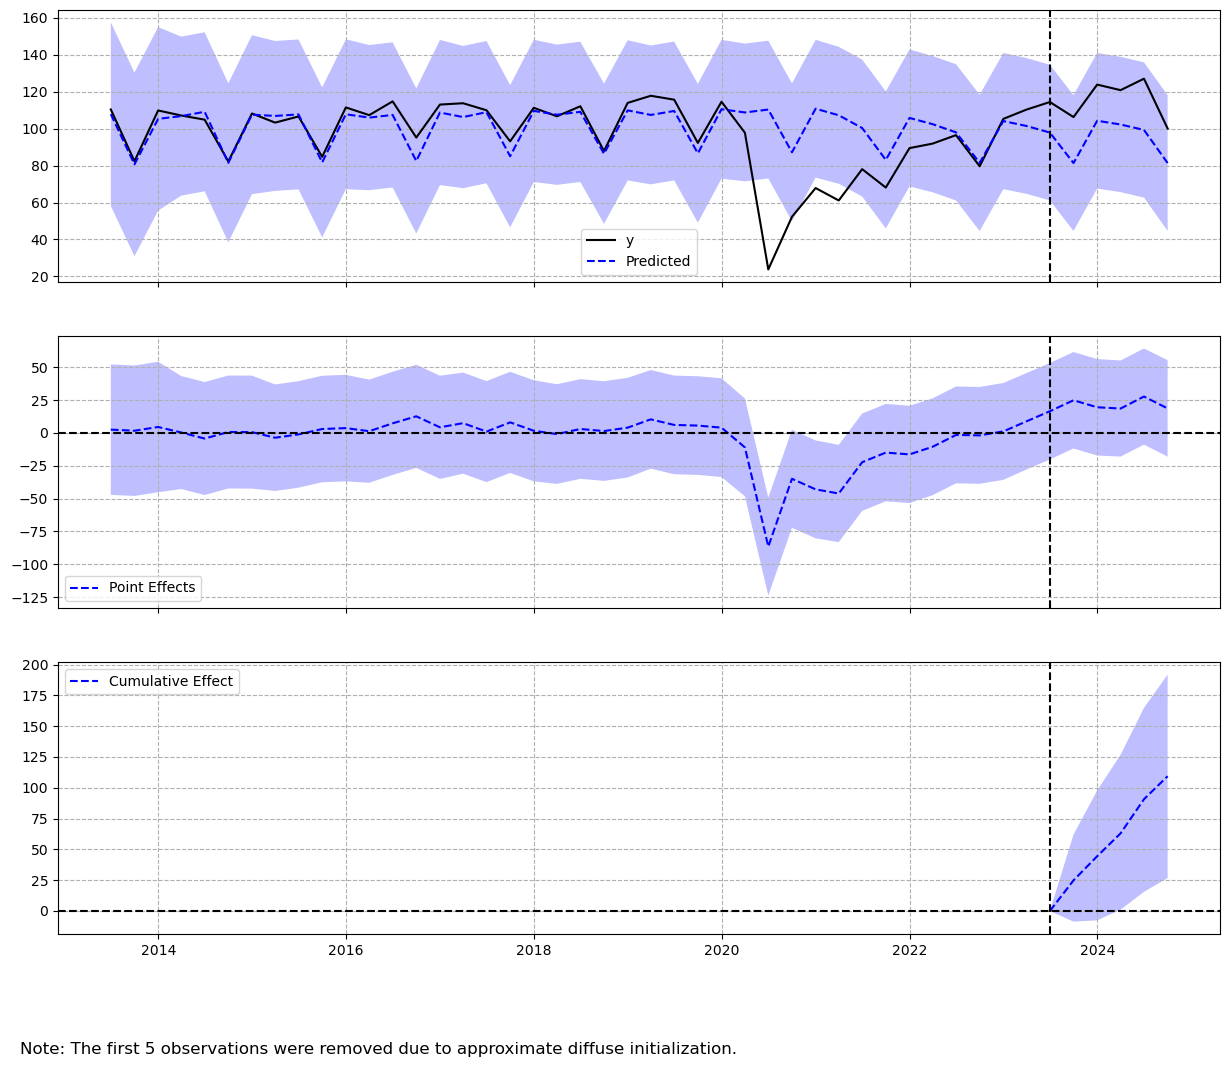

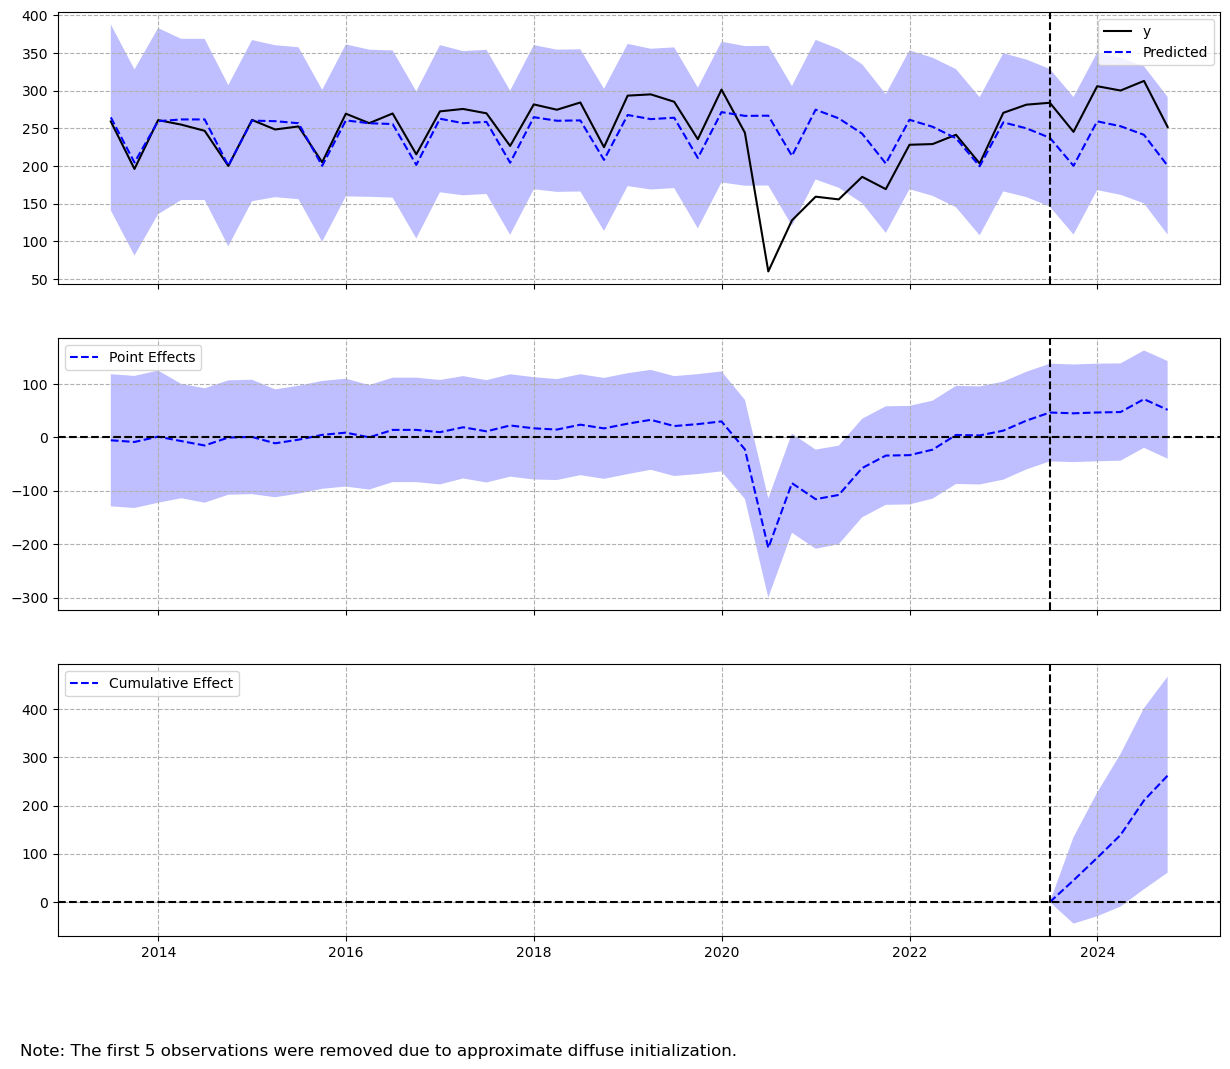

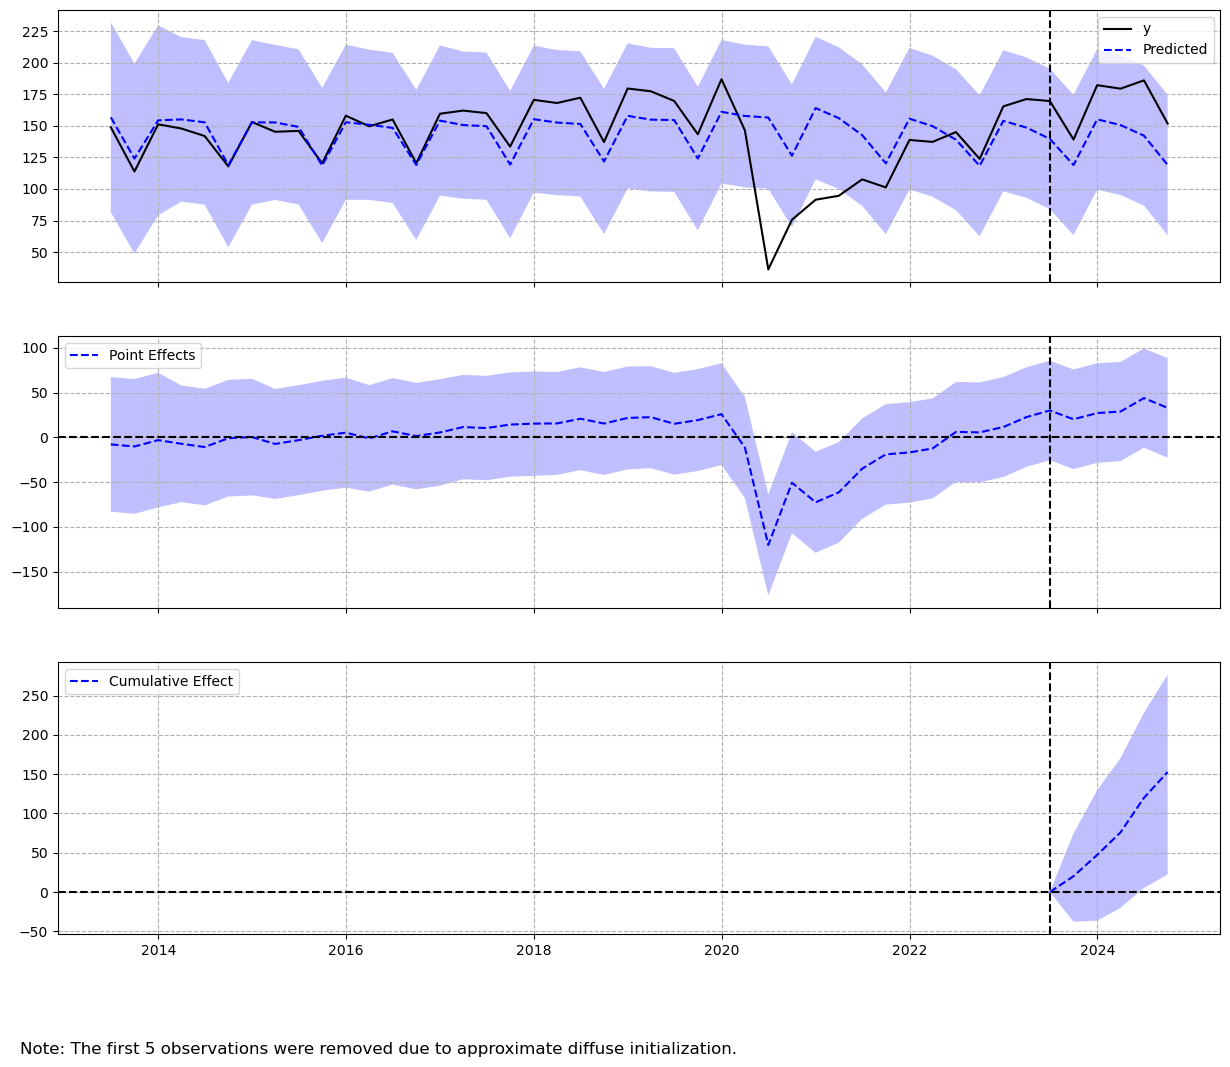

In [15]:
def train_and_plot_causal_impact(data, pre_period, post_period):
    # Entrenar el modelo CausalImpact
    ci = CausalImpact(data, pre_period, post_period, model_args={'fit_method': 'vi'},nseasons=[{'period': 4}], seasonal_duration=90)
    
    # Graficar los resultados
    ci.plot()
    plt.show()

# Definir el periodo de intervención
pre_period = ['2012-03-31', '2023-06-30']
post_period = ['2023-09-30', '2024-09-30']

# Asegúrate de que los periodos están dentro del rango de fechas de los datos
pre_period = [date for date in pre_period if date in df_autobus_trim.index.strftime('%Y-%m-%d').tolist()]
post_period = [date for date in post_period if date in df_autobus_trim.index.strftime('%Y-%m-%d').tolist()]

# Crear dataframes con las series temporales
data_autobus_trim = pd.DataFrame({'y': df_autobus_trim}).dropna()
data_combined_trim = pd.DataFrame({'y': df_combined_trim}).dropna()
data_metro_trim = pd.DataFrame({'y': df_metro_trim}).dropna()

# Entrenar y graficar para cada dataframe
train_and_plot_causal_impact(data_autobus_trim, pre_period, post_period)
train_and_plot_causal_impact(data_combined_trim, pre_period, post_period)
train_and_plot_causal_impact(data_metro_trim, pre_period, post_period)

In [17]:
# Obtener las predicciones del modelo CausalImpact
predicted_autobus_trim = ci.inferences['preds'].loc[data_autobus_trim.index]
predicted_combined_trim = ci.inferences['preds'].loc[data_combined_trim.index]
predicted_metro_trim = ci.inferences['preds'].loc[data_metro_trim.index]

# Calcular las métricas para cada serie temporal
mse_autobus, rmse_autobus, mape_autobus = calculate_metrics(data_autobus_trim['y'], predicted_autobus_trim)
mse_combined, rmse_combined, mape_combined = calculate_metrics(data_combined_trim['y'], predicted_combined_trim)
mse_metro, rmse_metro, mape_metro = calculate_metrics(data_metro_trim['y'], predicted_metro_trim)

# Imprimir los resultados
print(f"Autobús - MSE: {mse_autobus}, RMSE: {rmse_autobus}, MAPE: {mape_autobus}")
print(f"Combined - MSE: {mse_combined}, RMSE: {rmse_combined}, MAPE: {mape_combined}")
print(f"Metro - MSE: {mse_metro}, RMSE: {rmse_metro}, MAPE: {mape_metro}")

Autobús - MSE: 4532.147021916806, RMSE: 67.32122267098842, MAPE: 0.6410294024245738
Combined - MSE: 46075.75952890096, RMSE: 214.65264854853518, MAPE: 0.8467893386651043
Metro - MSE: 12989.047016211487, RMSE: 113.96950037712496, MAPE: 0.7418206843055317


***

## Conclusión Causal Impact

La evaluación de los modelos Causal Impact en las series temporales de pasajeros de autobús y metro de Madrid mostró que las predicciones generadas no alcanzan el nivel de precisión requerido para ofrecer resultados confiables. Esto sugiere que este enfoque no es adecuado para capturar las dinámicas complejas de estas series, probablemente debido a limitaciones en la estructura del modelo, la falta de covariables relevantes o la naturaleza intrínseca de los datos. Por lo tanto, se descarta el uso de Causal Impact para las predicciones finales, tenemos modelos que se ajustan mejor a los patrones observados en las series de pasajeros, como son los modelos ETS y Theta.